In [39]:
'''
This is the code of the portfolio analysis (CAPM model). 
We use investing.com as the data source. 
We consider the data from 01/01/2017 to 31/08/2018. 
'''

# Import packages
import os
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import pandas_datareader as pdr
import investpy


# Set the date bounds
# dt.datetime(2019,1,1)
start = '21/12/2016'
# dt.datetime.now().strftime('%d/%m/%Y')
end = '05/09/2018'



In [40]:
# Assets
USDJPY = investpy.get_currency_cross_historical_data(currency_cross = 'USD/JPY', from_date = start, to_date = end)
USDEUR = investpy.get_currency_cross_historical_data(currency_cross = 'USD/EUR', from_date = start, to_date = end)
BTCUSD = investpy.get_crypto_historical_data(crypto='Bitcoin', from_date = start, to_date = end)
XAUJPY = investpy.get_commodity_historical_data(commodity = 'Gold', from_date = start, to_date = end)
Topix_500 = investpy.indices.get_index_historical_data(index='Topix 500', country='Japan', from_date = start, to_date = end)


# Form a dataframe for consideration

In [74]:
# Extract the needed data (We take the close prices)
df = pd.concat([USDJPY['Close'], BTCUSD['Close'], USDEUR['Close'], XAUJPY['Close'], Topix_500['Close']], axis=1)


In [75]:
# Rename the columns
df.columns = ['USDJPY', 'BTCUSD', 'USDEUR', 'XAUJPY', 'Topix_500']
# Reset the index
df = df.reset_index()
# Change the date into datetime format
# df['Date'] = pd.to_datetime(df['Date'])
# Print some data for checking
# df.head()


In [115]:
# Fill all the Nan(s) by (linear) interpolation vertically
df = df.interpolate(method='linear', axis=0)
# Print some data for checking
# df.head()


In [79]:
# Create a column for USDJPY
df['BTCJPY'] = df['USDJPY'] * df['BTCUSD']
# Print some data for checking
# df.head()


In [116]:
# Select the rows within the date range (considering year 2017)
# Set up the conditions
condition_2017 = (df['Date'] >= '2016/12/31') & (df['Date'] <= '2017/12/31')
# Select the data in 2017
df_2017 = df.loc[condition_2017]


In [123]:
# Find the basic statistics of the rate of return
# We use the simple percentage change. 
df_2017[['USDEUR','BTCJPY','XAUJPY','Topix_500']].pct_change().dropna().describe()


,USDEUR,BTCJPY,XAUJPY,Topix_500
count,365.000000,365.000000,365.000000,365.000000
mean,-0.000361,0.008441,0.000365,0.000489
std,0.003630,0.049795,0.013152,0.005072
min,-0.013754,-0.163951,-0.061566,-0.021525
25%,-0.001930,-0.011246,-0.002718,-0.001910
50%,-0.000118,0.006850,0.000441,0.000463
75%,0.001570,0.034259,0.002568,0.002954
max,0.013820,0.254913,0.081360,0.022462


In [107]:
# Find the correlation of the rate of return
df_2017[['USDEUR','BTCJPY','XAUJPY','Topix_500']].corr()


,USDEUR,BTCJPY,XAUJPY,Topix_500
USDEUR,1.000000,-0.642513,-0.649333,-0.749253
BTCJPY,-0.642513,1.000000,0.356817,0.871262
XAUJPY,-0.649333,0.356817,1.000000,0.377940
Topix_500,-0.749253,0.871262,0.377940,1.000000


In [124]:
# Select the rows within the date range (considering year 2018 (Up to the end of August))
# Set up the conditions
condition_2018 = (df['Date'] >= '2017/12/31') & (df['Date'] <= '2018/09/01')
# Select the data in 2017
df_2018 = df.loc[condition_2018]


In [122]:
# Find the basic statistics of the rate of return
# We use the simple percentage change. 
df_2018[['USDEUR','BTCJPY','XAUJPY','Topix_500']].pct_change().dropna().describe()


,USDEUR,BTCJPY,XAUJPY,Topix_500
count,244.000000,244.000000,244.000000,244.000000
mean,0.000144,-0.001669,-0.000219,-0.000206
std,0.003751,0.046154,0.013053,0.006914
min,-0.012634,-0.171181,-0.062658,-0.042239
25%,-0.001536,-0.027355,-0.002868,-0.002865
50%,-0.000335,0.000337,-0.000213,0.000099
75%,0.001762,0.022740,0.001743,0.003645
max,0.019102,0.144186,0.074060,0.027394


In [179]:
# Find the correlation of the rate of return
df_2018[['USDEUR','BTCJPY','XAUJPY','Topix_500']].corr()


,USDEUR,BTCJPY,XAUJPY,Topix_500
USDEUR,1.000000,-0.446276,-0.841807,-0.211573
BTCJPY,-0.446276,1.000000,0.367271,0.722248
XAUJPY,-0.841807,0.367271,1.000000,0.269460
Topix_500,-0.211573,0.722248,0.269460,1.000000


In [151]:
# Define the expected portfolio return and variance
# data must be a pd.Dataframe
def portfolio_return(data, weights):
    return np.sum(data.mean() * weights)

def portfolio_volatility(data, weights):
    return np.sqrt(np.dot(weights.T, np.dot(data.cov(), weights)))

In [173]:
# To find the CAPM model in 2017
port_return = []
port_volatility = []
num_of_assets = 4
data_considered = df_2017[['USDEUR','BTCJPY','XAUJPY','Topix_500']].pct_change().dropna()

for i in range(data_considered.shape[0] * 20):
    weights = np.random.random(num_of_assets)
    # Normalization to proportion
    weights /= np.sum(weights)
    port_return.append(portfolio_return(data_considered, weights))
    port_volatility.append(portfolio_volatility(data_considered, weights))

port_return = np.array(port_return)
port_volatility = np.array(port_volatility)


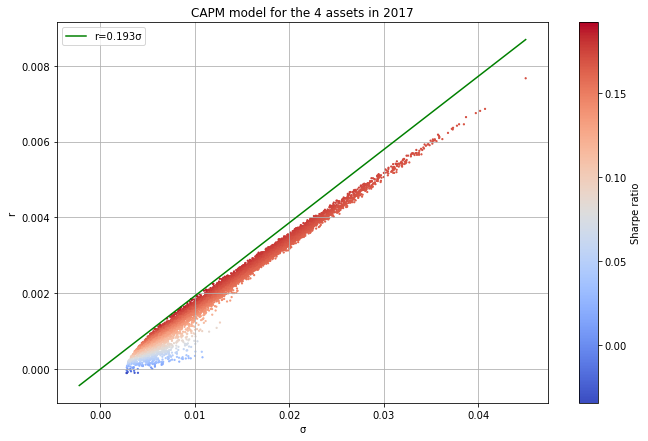

In [178]:
# Plot the result
# Since the interest rate of national bond of Japan was nearly zero in 2017, 
# we take the risk free rate as zero for the calculation of the Sharpe ratio. 
plt.figure(figsize=(11,7))
plt.scatter(port_volatility, port_return, c = port_return/ port_volatility,
           marker='o', s=1.5, cmap = 'coolwarm')
plt.xlabel(chr(963))                          # chr(963) is a Greek sigma symbol. 
plt.ylabel('r')
plt.grid(True)
plt.colorbar(label = 'Sharpe ratio')
plt.title('CAPM model for the ' + str(num_of_assets) + ' assets in 2017')

# Plot a linear line tangent to the portfolio frontier
x = np.linspace(port_volatility.min()-0.005, port_volatility.max(), 100)
slope = 0.193
y = slope * x + 0.0
plt.plot(x, y, '-g', label = 'r=' + str(slope) + chr(963))
plt.xlabel(chr(963))                          # chr(963) is a Greek sigma symbol. 
plt.ylabel('r')
plt.grid(True)
plt.legend(loc='upper left')

# Show the above plots in the same graph
plt.show()